In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, Operator, random_hermitian, SparsePauliOp
from qiskit_ibm_runtime.fake_provider import FakeManilaV2 # Retired quantum processor
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.interpolate import UnivariateSpline
from scipy.stats import chi2

import sys
import os

In [2]:
backend_name = "aer" #manila, aer, ibm, ionq
trotter_order= "second" #first, second

<!-- simulator_backend = provider.get_backend("simulator")
# Run the circuit on IonQ's platform:
job = simulator_backend.run(qc, shots=10000)

# Print the counts
print(job.get_counts()) -->

In [3]:
import qiskit 
qiskit.version.get_version_info() 

'1.1.1'

In [4]:
import qiskit_ibm_runtime 
qiskit_ibm_runtime .version.get_version_info() 

'0.25.0'

In [5]:

#ionq backend start
from qiskit import transpile

# Load the API key from the environment variable
api_key = os.getenv('IONQ_API_KEY')
from qiskit_ionq import IonQProvider
# provider = IonQProvider()
api_key = "zneojFDA2Je63szoO1GYFi7EwQO9FEnQ"
provider = IonQProvider(api_key)
print(provider.backends())

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [6]:

# Determine the correct path for the 'src' directory
if '__file__' in globals():
    # Running as a script
    src_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'src'))
else:
    # Running in an interactive environment like Jupyter Notebook
    src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

sys.path.append(src_dir)


In [7]:
from hamiltonian import construct_hamiltonian
from momentum import momentum
from evolve import evolve_and_measure_circuit
from meas_counts import meas_counts
from sigma_statistics import calc_mean_and_sigma
from constants import hbar, c , eV, MeV, GeV, G_F, kB

In [8]:
# Set OMP_NUM_THREADS environment variable to the number of available CPU cores
# os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())

In [9]:
def initialize_parameters():
    N_sites_eachflavor= 1 # total sites/particles/qubits that are evenly spaced "for each (electron) flavor" 
    N_sites = 2* (N_sites_eachflavor) # total particles/sites/qubits for all neutrino and anti neutrino electron flavored 
    m1 = -0.008596511*eV #ergs #1st mass eigenstate of neutrino in Richers(2021)
    m2 = 0*eV   #ergs #2nd mass eigenstate of neutrino in Richers(2021)
    delta_m_squared = (m2**2 - m1**2) # mass square difference # (erg^2)
    t1 = 0.0088298 
    t2 = 0.011662
    del_t  = t1 - t2

    shots = 10240
    trotter_steps= 1000 # Number of Trotter steps per time step
    optimization_level = 3
    if backend_name == 'manila':
        backend = FakeManilaV2()
    elif backend_name == 'aer':
        # backend = AerSimulator(method='automatic')
        backend = AerSimulator(method='matrix_product_state')
        # Configure backend options for matrix product state simulation
        backend.set_options(
            matrix_product_state_max_bond_dimension=1,  #  (int): Sets a limit on the number of Schmidt coefficients retained at the end of the svd algorithm. Coefficients beyond this limit will be discarded. # (Default: None, i.e., no limit on the bond dimension).
            matrix_product_state_truncation_threshold=1e-100,  # (double): Discard the smallest coefficients for which the sum of their squares is smaller than this threshold. (Default: 1e-16).
            mps_sample_measure_algorithm="mps_apply_measure",  # (str): Choose between "mps_apply_measure" and "mps_probabilities" consult https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html before choosing
            # mps_log_data=True,  # if True, output logging data of the MPS structure: bond dimensions and values discarded during approximation. (Default: False)
            # mps_swap_direction="mps_swap_right",  # (str): Determine the direction of swapping the qubits when internal swaps are inserted for a 2-qubit gate. Possible values are “mps_swap_right” and “mps_swap_left”. (Default: “mps_swap_left”)
            # chop_threshold=1e-8,  # (float): This option sets a threshold for truncating snapshots (Default: 1e-8).
            # mps_parallel_threshold=14,  # (int): This option sets OMP number threshold (Default: 14).
            # mps_omp_threads=1,  #  (int): This option sets the number of OMP threads (Default: 1).
            # mps_omp_threads=int(os.environ["OMP_NUM_THREADS"]),  # Use all available cores
            # mps_lapack=True  # (bool): This option indicates to compute the SVD function using OpenBLAS/Lapack interface (Default: False).
        )
    elif backend_name == 'ibm':
        # Define the service to access IBM Quantum systems.
        service = QiskitRuntimeService()
        backend = service.least_busy(operational=True, simulator=False)
    elif backend_name == 'ionq':
        backend = provider.get_backend("simulator")
    df = 1 # degrees of freedom for chisquare test
    τ = 1.666e-4  # Time step
    ttotal = 1.666e-2 # total time of evolution # sec #variable
    times = np.arange(0, τ  + ttotal, τ)  # Define time steps
    L = 1e7 # cm # domain size # (aka big box length)
    n_νₑ =  2.92e24 # cm^-3 # number density of electron flavor neutrino
    n_νₑ̄ =  n_νₑ # cm^-3 # number density of electron flavor antineutrino
    Eνₑ =  50*MeV # energy of all neutrinos (P.S the its negative is energy of all antineutrinos)
    Eνₑ̄ = -1 * Eνₑ # specific to my case only. Since all neutrinos have same energy, except in my case anti neutrinos are moving in opposite direction to give it a negative sign
    Δx = L # length of the box of interacting neutrinos at a site in cm
    Δp = L # width of shape function # not being used in this test but defined to keep the evolve function arguments consistent.
    t1 = 0.0084003052 #choose initial time for growth rate calculation #variable, not being used in this test
    t2 = 0.011700318 #choose final time for growth rate calculation #variable, not being used in this test
    theta_nu = 1.74532925E-8  #1e-6 degrees # mixing_angle # = 1.74532925E-8 radians 
    periodic = True

    V = L**3# volume of the big box containing all sites/particles
    # Create an array of dimension N and fill it half with values of sites containing all electron neutrinos 
    # # and other half with sites containing electron anti-neutrino. 
    N_νₑ  = n_νₑ * V 
    N_1 = np.full(N_sites // 2, N_νₑ)
    N_νₑ̄  = n_νₑ̄ * V 
    N_2 = np.full(N_sites // 2, N_νₑ̄)

    # Concatenate the arrays to get the total number of neutrinos
    N = np.concatenate((N_1, N_2))
    
    # Create a B vector which would be same for all N particles
    B = np.array([-np.sin(2 * theta_nu), 0, np.cos(2 * theta_nu)])
    B = B / np.linalg.norm(B)



    # Function to generate x_array such that the first particle is at position L/(2*N_sites)
    # while subsequent particles are at a position incremental by L/N_sites (grid style)
    def generate_x_array(N_sites, L):
        return [(i - 0.5) * L / N_sites for i in range(1, N_sites + 1)]
    
    # Generate position arrays
    x = generate_x_array(N_sites, L)
    y = generate_x_array(N_sites, L)
    z = generate_x_array(N_sites, L)
    
    # Function to generate a momentum array in px direction
    # that depicts the energy of neutrinos and anti-neutrinos in opposing beams
    def generate_px_array(N_sites):
        half_N_sites = N_sites // 2
        return np.concatenate([np.full(half_N_sites, Eνₑ), np.full(half_N_sites, Eνₑ̄)])

    def generate_py_array(N_sites):
        half_N_sites = N_sites // 2
        return np.concatenate([np.zeros(half_N_sites), np.zeros(half_N_sites)])

    def generate_pz_array(N_sites):
        half_N_sites = N_sites // 2
        return np.concatenate([np.zeros(half_N_sites), np.zeros(half_N_sites)])

    # Generate momentum arrays
    px = generate_px_array(N_sites)
    py = generate_py_array(N_sites)
    pz = generate_pz_array(N_sites)

    # p matrix with numbers generated from the p_array for all components (x, y, z)
    p = np.column_stack((px, py, pz))

    # Create an array with the first half as 1 and the rest as -1
    energy_sign = np.array([-1 if i < N_sites // 2 else 1 for i in range(N_sites)])
    p_mod, p_hat = momentum(p, N_sites)
    # Calculate omega for each site
    omega = [delta_m_squared / (2 * p_mod[i]) * energy_sign[i] for i in range(N_sites)]
    print(omega)

    #modify this shape_name dict thing
    shape_name = 1  # variable.  #Select a shape function based on the shape_name variable form the list defined in dictionary in shape_func file

    return N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared, t1, t2, del_t, Eνₑ, shape_name , shots, trotter_steps, backend, df, τ, times,ttotal,optimization_level, periodic

In [10]:
# Function to find the value of rho_emu at a given time
def get_rho_at_time(time_array, rho_array, target_time):
    # Find the index of the closest time value in time_array
    idx = (np.abs(np.array(time_array) - target_time)).argmin()
    # Return the corresponding rho_emu value
    return rho_array[idx]

In [11]:
def evolve_and_simulate(times, omega,delta_m_squared,del_t, Eνₑ,  N_sites,x, p, L, pauli_terms, theta_nu, backend, shots, τ, df, ttotal, optimization_level,periodic, trotter_steps, trotter_order):
    datadir = os.path.join(os.getcwd(), "..", "misc", "datafiles", "FFI", f"par_{N_sites}", f"tt_{ttotal}", f"shots_{shots}")
    if not os.path.isdir(datadir):
        os.makedirs(datadir)
        
    # Simulation and expected value calculation
    sigma_x_values = []
    sigma_y_values = []
    sigma_z_values = []
    ρₑₑ_array = []
    ρ_μμ_array = []
    ρₑμ_array = []
    survival_probabilities = []
    # Initialize a list to store sigma_x, sigma_y  and sigma_z values
    sigma_x_list = []
    sigma_xbar_i = []
    sigma_ybar_i = []
    sigma_zbar_i = []
    # Create empty arrays to store the respective values
    x_values = []
    px_values = []
    # Extract output of p_hat and p_mod for the p vector defined above for all sites
    p_mod, p_hat = momentum(p, N_sites)
    p_hat_x = [sub_array[0] for sub_array in p_hat]
    
    for t in times:
        counts_z, isa_circuit_z = meas_counts(t, pauli_terms, N_sites, theta_nu, trotter_steps, trotter_order, 'Z', backend_name, backend,optimization_level, shots)

        x_values.append(x.copy())  # Record x values at each time step
        px = p[:, 0]  # Extracting the first column (which corresponds to px values)
        px_values.append(px.copy())  # Record px values at each time step

        for i in range(N_sites):
            x[i] += p_hat_x[i] * c * τ
            if periodic:
                # Wrap around position from 0 to domain size L
                x[i] = x[i] % L

                # Checking if the updated x[i] satisfies the boundary conditions
                assert 0 <= x[i] <= L
                
        sigma_z, std_sigma_z = calc_mean_and_sigma(counts_z, shots, 'Z')

        counts_x, isa_circuit_x = meas_counts(t, pauli_terms, N_sites, theta_nu, trotter_steps, trotter_order, 'X', backend_name, backend,optimization_level, shots)

        sigma_x, std_sigma_x = calc_mean_and_sigma(counts_x, shots, 'X')

        counts_y, isa_circuit_y = meas_counts(t, pauli_terms, N_sites, theta_nu, trotter_steps, trotter_order, 'Y', backend_name, backend,optimization_level, shots)

        sigma_y, std_sigma_y = calc_mean_and_sigma(counts_y, shots, 'Y')

        # Calculate survival probability
        survival_probability = (1 - sigma_z) / 2
        print(f"t: {t}, survival_probability: {survival_probability}\n")
        
        # Append values to the respective lists
        sigma_x_values.append(sigma_x)
        sigma_y_values.append(sigma_y)
        sigma_z_values.append(sigma_z)
        survival_probabilities.append(survival_probability)
        # Store the std_sigma_x value in sigma_xbar_i , sigma_ybar_i and, sigma_zbar_i array
        sigma_xbar_i.append(std_sigma_x)
        sigma_ybar_i.append(std_sigma_y)
        sigma_zbar_i.append(std_sigma_z)
        
        
        # Recall that in our code sigma_z = 2 * Sz to make sure these expressions are consistent with "Sz in ITensors"
        ρₑₑ = ((sigma_z) + 1) / 2
        ρₑₑ_array.append(abs(ρₑₑ))
        ρ_μμ = ((-1*sigma_z) + 1) / 2
        ρ_μμ_array.append(abs(ρ_μμ))
        ρₑμ = np.sqrt((sigma_x/2)**2 + (sigma_y/2)**2)  
        ρₑμ_array.append(ρₑμ)
        
                
        if t == ttotal:
            break

    # Find rho_emu at t1 and t2
    rho_emu_at_t1 = get_rho_at_time(times, ρₑμ_array, t1)
    rho_emu_at_t2 = get_rho_at_time(times, ρₑμ_array, t2)

    Im_omega = (1/del_t ) * np.log(rho_emu_at_t2 / rho_emu_at_t1) 
    print("Growth rate= ", Im_omega)
    
    analytic_growth_rate=  (abs(delta_m_squared)/ (2*hbar* Eνₑ)) # analytic growth rate 

    # # Create a spline of the survival probabilities
    # spline = UnivariateSpline(times, survival_probabilities, s=0.02)
    # survival_probabilities = spline(times) # smoothed survival_probabilities array
    
    
    # spline = UnivariateSpline(times, ρₑₑ_array, s=0.02)
    # ρₑₑ_array = spline(times) # smoothed ρₑₑ_array array
    
    # spline = UnivariateSpline(times, ρ_μμ_array, s=0.02)
    # ρ_μμ_array= spline(times) # smoothed ρ_μμ_array
    
    # spline = UnivariateSpline(times, ρₑμ_array, s=0.02)
    # ρₑμ_array = spline(times) # smoothed ρₑμ_array 
    
    
    fname1 = os.path.join(datadir, "t_<s_z>_<s_y>_<s_x>.dat")
    np.savetxt(fname1, np.column_stack((times, sigma_z_values, sigma_y_values, sigma_x_values)))
    fname2 = os.path.join(datadir, "t_probsurv.dat")
    np.savetxt(fname2, np.column_stack((times, survival_probabilities)))
    fname3 = os.path.join(datadir, "t_xsiteval.dat")
    np.savetxt(fname3, np.column_stack((times, x_values)))
    fname4 = os.path.join(datadir, "t_pxvalsite.dat")
    np.savetxt(fname4, np.column_stack((times, px_values)))
    fname5 = os.path.join(datadir, "t_ρₑₑ.dat")
    np.savetxt(fname5, np.column_stack((times, ρₑₑ_array)))
    fname6 = os.path.join(datadir, "t_ρ_μμ.dat")
    np.savetxt(fname6, np.column_stack((times, ρ_μμ_array)))
    fname7 = os.path.join(datadir, "t_ρₑμ.dat")
    np.savetxt(fname7, np.column_stack((times, ρₑμ_array)))
    fname8 = os.path.join(datadir, "t_sigma_xbar_i.dat")
    np.savetxt(fname8, np.column_stack((times, sigma_xbar_i)))
    fname9 = os.path.join(datadir, "t_sigma_ybar_i.dat")
    np.savetxt(fname9, np.column_stack((times, sigma_ybar_i)))
    fname10 = os.path.join(datadir, "t_sigma_zbar_i.dat")
    np.savetxt(fname10, np.column_stack((times, sigma_zbar_i)))

    return sigma_x_values, sigma_y_values, sigma_z_values, survival_probabilities, x_values, pₓ_values, ρₑₑ_array, ρ_μμ_array, ρₑμ_array, isa_circuit_x, sigma_xbar_i, sigma_ybar_i, sigma_zbar_i, Im_omega


In [12]:
def chi_square_test(par, tt, shots):
    # File paths
    file_path1 = f"../misc/datafiles/FFI/par_{par}/tt_{tt}/shots_{shots}/t_<s_z>_<s_y>_<s_x>.dat"
    # file_path2 = f"../misc/datafiles/FFI/par_{par}/tt_{tt}/t_<Sz>_<Sy>_<Sx>_CCold.dat"
    file_path2 = f"../misc/datafiles/FFI/par_{par}/tt_{tt}/t_<Sz>_<Sy>_<Sx>_MF.dat"
    file_path3 = f"../misc/datafiles/FFI/par_{par}/tt_{tt}/shots_{shots}/t_sigma_xbar_i.dat"
    file_path4 = f"../misc/datafiles/FFI/par_{par}/tt_{tt}/shots_{shots}/t_sigma_ybar_i.dat"
    file_path5 = f"../misc/datafiles/FFI/par_{par}/tt_{tt}/shots_{shots}/t_sigma_zbar_i.dat"

    # Read and load the data from the files
    s_data_QC = np.loadtxt(file_path1)  # observed data (sigma_x_QC)
    S_data_CC = np.loadtxt(file_path2)  # expected data (sigma_x_CC)
    sigma_xi_data_QC = np.loadtxt(file_path3)  # standard deviation (sigma_xbar_i)
    sigma_yi_data_QC = np.loadtxt(file_path4)  # standard deviation (sigma_ybar_i)
    sigma_zi_data_QC = np.loadtxt(file_path5)  # standard deviation (sigma_zbar_i)

    # Extract the arrays 
    times_CC = S_data_CC[:, 0]
    times_QC = s_data_QC[:, 0]
    times_sigma_xi_QC = sigma_xi_data_QC[:, 0]
    
    sx_array_QC = s_data_QC[:, 3]* 1/2  # observed values (y_i) # divided by 2 to accomodate the factor of 2 coming in Sx classical simulation 
    Sx_array_CC = S_data_CC[:, 3]  # expected values (f(x_i))
    sy_array_QC = s_data_QC[:, 2]* 1/2  # observed values (y_i) # divided by 2 to accomodate the factor of 2 coming in Sy classical simulation 
    Sy_array_CC = S_data_CC[:, 2]  # expected values (f(x_i))
    sz_array_QC = s_data_QC[:, 1]* 1/2  # observed values (y_i) # divided by 2 to accomodate the factor of 2 coming in Sz classical simulation 
    Sz_array_CC = S_data_CC[:, 1]  # expected values (f(x_i))
    
    
    sigma_xi_array_QC = sigma_xi_data_QC[:, 1]  # standard deviations (sigma_xi)
    sigma_yi_array_QC = sigma_yi_data_QC[:, 1]  # standard deviations (sigma_yi)
    sigma_zi_array_QC = sigma_zi_data_QC[:, 1]  # standard deviations (sigma_zi) 

    print(f"Sx_array_CC: {Sx_array_CC}")
    print(f"sx_array_QC: {sx_array_QC}")
    print(f"sigma_xi_array_QC: {sigma_xi_array_QC}")
    
    
    print(f"Sy_array_CC: {Sy_array_CC}")
    print(f"sy_array_QC: {sy_array_QC}")
    print(f"sigma_yi_array_QC: {sigma_yi_array_QC}")
    
    
    print(f"Sz_array_CC: {Sz_array_CC}")
    print(f"sz_array_QC: {sz_array_QC}")
    print(f"sigma_zi_array_QC: {sigma_zi_array_QC}")
    
    # Ensure the arrays are of the same length
    if len(sx_array_QC) != len(Sx_array_CC) or len(sx_array_QC) != len(sigma_xi_array_QC):
        raise ValueError("Arrays must be of the same length for chi-square calculation")

    # Compute chi-square value
    chi_square_value = np.mean(((Sx_array_CC - sx_array_QC ) / sigma_xi_array_QC) ** 2)
    print(f"Chi-square value: {chi_square_value}")
    
    # Ensure the arrays are of the same length
    if len(sy_array_QC) != len(Sy_array_CC) or len(sy_array_QC) != len(sigma_yi_array_QC):
        raise ValueError("Arrays must be of the same length for chi-square calculation")

    # Compute chi-square value
    chi_square_value = np.mean(((Sy_array_CC - sy_array_QC ) / sigma_yi_array_QC) ** 2)
    print(f"Chi-square value: {chi_square_value}")
    
    # Ensure the arrays are of the same length
    if len(sz_array_QC) != len(Sz_array_CC) or len(sz_array_QC) != len(sigma_zi_array_QC):
        raise ValueError("Arrays must be of the same length for chi-square calculation")

    # Compute chi-square value
    chi_square_value = np.mean(((Sz_array_CC - sz_array_QC ) / sigma_zi_array_QC) ** 2)
    print(f"Chi-square value: {chi_square_value}")
    
    # Assert that chi-square value is less than or equal to 1 sigma (std of mean)
    # assert chi_square_value <= 1, f"Chi-square value is too high: {chi_square_value}. It should be <= 1 sigma."

    return chi_square_value, Sx_array_CC, sx_array_QC, sigma_xi_array_QC, Sy_array_CC, sy_array_QC, sigma_yi_array_QC, Sz_array_CC, sz_array_QC, sigma_zi_array_QC





In [13]:
def plot_results(times,shots, sigma_x_values, sigma_y_values, sigma_z_values, survival_probabilities,x_values, pₓ_values, ρₑₑ_array, ρ_μμ_array, ρₑμ_array, Sx_array_CC, Sy_array_CC, Sz_array_CC, sx_array_QC, sy_array_QC, sz_array_QC, sigma_xi_array_QC, sigma_yi_array_QC, sigma_zi_array_QC, N_sites,ttotal):
    plotdir = os.path.join(os.getcwd(), "..", "misc", "plots", "FFI", f"par_{N_sites}", f"tt_{ttotal}", f"shots_{shots}")
    if not os.path.isdir(plotdir):
        os.makedirs(plotdir)

    plt.plot(times, survival_probabilities, label='Survival Probability')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability at site 1')
    plt.title(f'Survival Probability at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"t_p_vs_symmetric_del_omega_for_N_sites{N_sites}.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    plt.semilogy(times, ρ_μμ_array, label='<ρ_μμ>')
    plt.xlabel('Time')
    plt.ylabel('<ρ_μμ> at site 1')
    plt.title(f'<ρ_μμ> at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"<ρ_μμ>_vs_t_self-interactions_w_geo_MB_FFI.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    
    plt.semilogy(times, ρₑₑ_array, label='<ρₑₑ>')
    plt.xlabel('Time')
    plt.ylabel('<ρₑₑ> at site 1')
    plt.title(f'<ρₑₑ> at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"<ρₑₑ>_vs_t_self-interactions_w_geo_MB_FFI.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    plt.semilogy(times, ρₑμ_array, label='<ρₑμ>')
    plt.xlabel('Time')
    plt.ylabel('<ρₑμ> at site 1')
    plt.title(f'<ρₑμ> at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"<ρₑμ>_vs_t_self-interactions_w_geo_MB_FFI.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    plt.plot(times, sigma_z_values, label='<Sz>')
    plt.xlabel('Time')
    plt.ylabel('<Sz> at site 1')
    plt.title(f'<Sz> at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"<Sz>_vs_t_self-interactions_w_geo_MB_FFI.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    plt.plot(times, sigma_y_values, label='<Sy>')
    plt.xlabel('Time')
    plt.ylabel('<Sy> at site 1')
    plt.title(f'<Sy> at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"<Sy>_vs_t_self-interactions_w_geo_MB_FFI.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    plt.plot(times, sigma_x_values, label='<Sx>')
    plt.xlabel('Time')
    plt.ylabel('<Sx> at site 1')
    plt.title(f'<Sx> at site 1 vs Time ({N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction)')
    plt.savefig(os.path.join(plotdir, f"<Sx>_vs_t_self-interactions_w_geo_MB_FFI.pdf"))
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
    
    plt.title(f"Position Evolution for {N_sites} Qubits, \n $ H_{{vac}} + H_{{SI}}$ Term), All-to-All Interaction")
    plt.xlabel("Position (x)")
    plt.ylabel("Time (s)")
    for site in range(N_sites):
        site_positions = [x_values[t][site] for t in range(len(x_values))]
        plt.plot(site_positions, times, label=f"Site {site+1}")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig(os.path.join(plotdir, f"Particles_position_evolution.pdf"))
    plt.show()
    
    
    plt.title("Qubits Momentum Evolution")
    plt.xlabel("Momentum in x direction (pₓ)")
    plt.ylabel("Time (s)")
    for site in range(N_sites):
        site_momentum = [px_values[t][site] for t in range(len(px_values))]
        plt.plot(site_momentum, times, label=f"Site {site+1}")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.savefig(os.path.join(plotdir, f"Particles_momentum_evolution.pdf"))
    plt.show()
    
    # Plotting sx_array_QC with error bars
    plt.errorbar(times, sx_array_QC, yerr=sigma_xi_array_QC, fmt='o',label='sigma_xi_QC')
    plt.plot(times, sx_array_QC, '-', label='sx_array_QC')
    plt.plot(times, Sx_array_CC, '-', label='Sx_array_CC')
    plt.xlabel('Time')
    plt.title('$\chi^2$ test for variations in classical and quantum simulation $\sigma_x$ data')
    plt.savefig(os.path.join(plotdir, f"chi_square_Sx.pdf"))
    plt.legend()
    plt.show()
    
    # Plotting sy_array_QC with error bars
    plt.errorbar(times, sy_array_QC, yerr=sigma_yi_array_QC, fmt='o',label='sigma_yi_QC')
    plt.plot(times, sy_array_QC, '-', label='sy_array_QC')
    plt.plot(times, Sy_array_CC, '-', label='Sy_array_CC')
    plt.xlabel('Time')
    plt.title('$\chi^2$ test for variations in classical and quantum simulation $\sigma_y$ data')
    plt.savefig(os.path.join(plotdir, f"chi_square_Sy.pdf"))
    plt.legend()
    plt.show()
    
    # Plotting sz_array_QC with error bars
    plt.errorbar(times, sz_array_QC, yerr=sigma_zi_array_QC, fmt='o',label='sigma_zi_QC')
    plt.plot(times, sz_array_QC, '-', label='sz_array_QC')
    plt.plot(times, Sz_array_CC, '-', label='Sz_array_CC')
    plt.xlabel('Time')
    plt.title('$\chi^2$ test for variations in classical and quantum simulation $\sigma_z$ data')
    plt.savefig(os.path.join(plotdir, f"chi_square_Sz.pdf"))
    plt.legend()
    plt.show()
    


[np.float64(1.18401104199987e-24), np.float64(-1.18401104199987e-24)]
Circuit depth=  12002
Gate counts at time step 0.0: OrderedDict([('rxx', 2000), ('ryy', 2000), ('rzz', 2000), ('x', 1), ('measure', 1)])
Number of two-qubit gates at time step 0.0: 6000
Size of the circuit at time step 0.0: 6002
Circuit depth=  12003


Gate counts at time step 0.0: OrderedDict([('rxx', 2000), ('ryy', 2000), ('rzz', 2000), ('x', 1), ('h', 1), ('measure', 1)])
Number of two-qubit gates at time step 0.0: 6000
Size of the circuit at time step 0.0: 6003
Circuit depth=  12004
Gate counts at time step 0.0: OrderedDict([('rxx', 2000), ('ryy', 2000), ('rzz', 2000), ('x', 1), ('u2', 1), ('measure', 1)])
Number of two-qubit gates at time step 0.0: 6000
Size of the circuit at time step 0.0: 6003
t: 0.0, survival_probability: 0.0

Circuit depth=  12002
Gate counts at time step 0.0001666: OrderedDict([('rxx', 2000), ('ryy', 2000), ('rzz', 2000), ('u3', 2000), ('x', 1), ('measure', 1)])
Number of two-qubit gates at time step 0.0001666: 6000
Size of the circuit at time step 0.0001666: 8002
Circuit depth=  12003
Gate counts at time step 0.0001666: OrderedDict([('rxx', 2000), ('ryy', 2000), ('rzz', 2000), ('u3', 2000), ('x', 1), ('h', 1), ('measure', 1)])
Number of two-qubit gates at time step 0.0001666: 6000
Size of the circuit at ti

/tmp/ipykernel_731032/1310643212.py:69: RuntimeWarning: divide by zero encountered in divide
  chi_square_value = np.mean(((Sz_array_CC - sz_array_QC ) / sigma_zi_array_QC) ** 2)
/tmp/ipykernel_731032/1310643212.py:69: RuntimeWarning: invalid value encountered in divide
  chi_square_value = np.mean(((Sz_array_CC - sz_array_QC ) / sigma_zi_array_QC) ** 2)


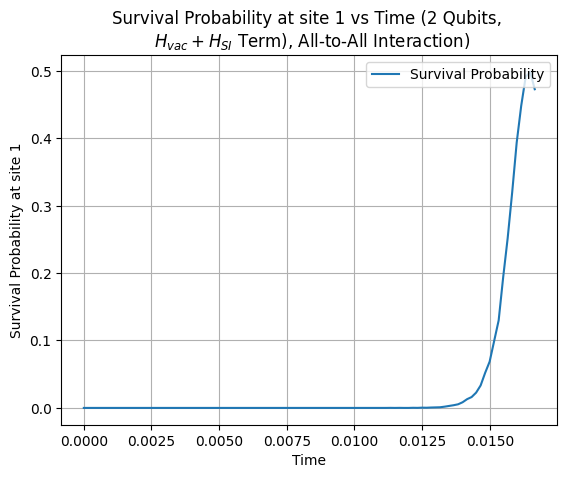

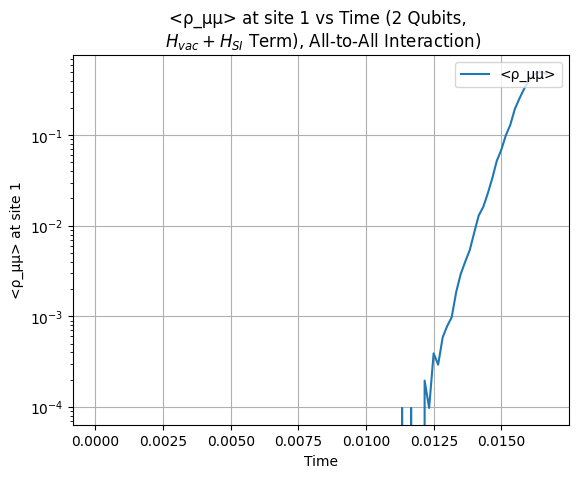

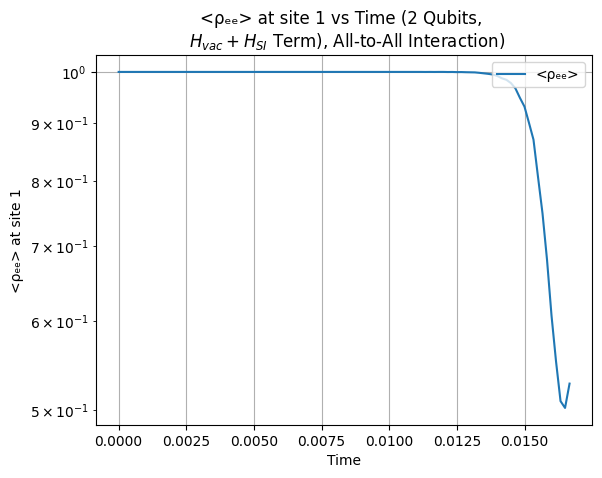

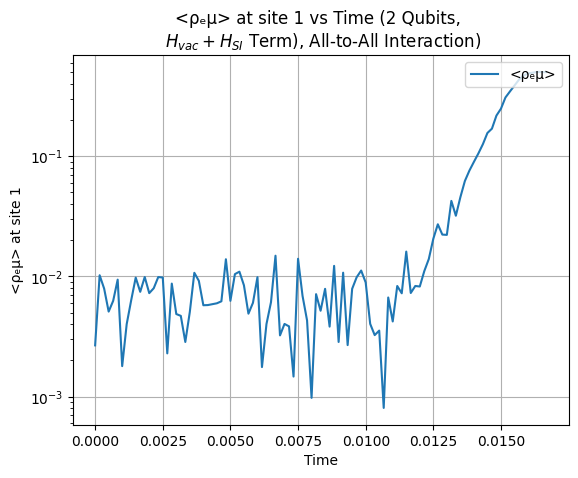

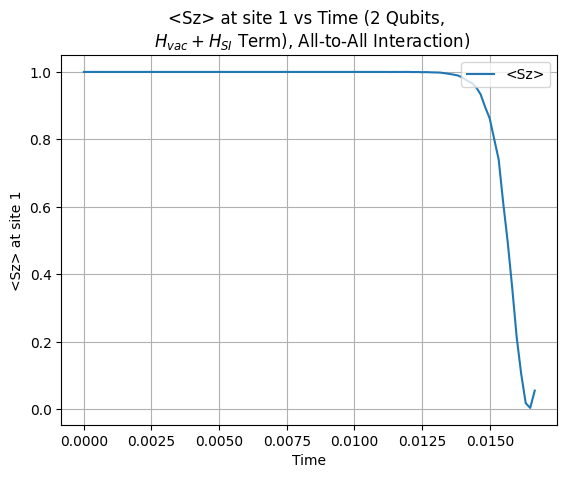

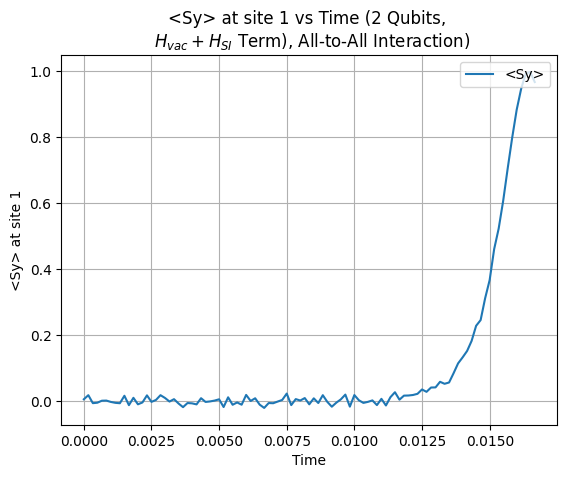

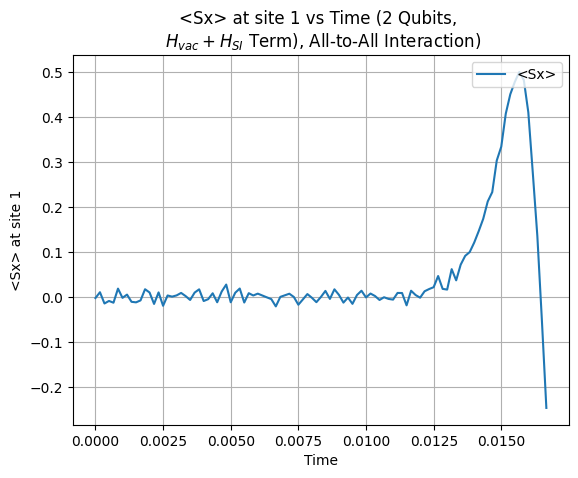

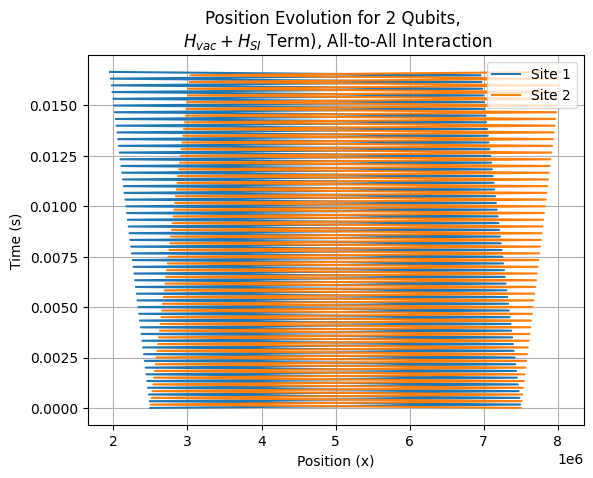

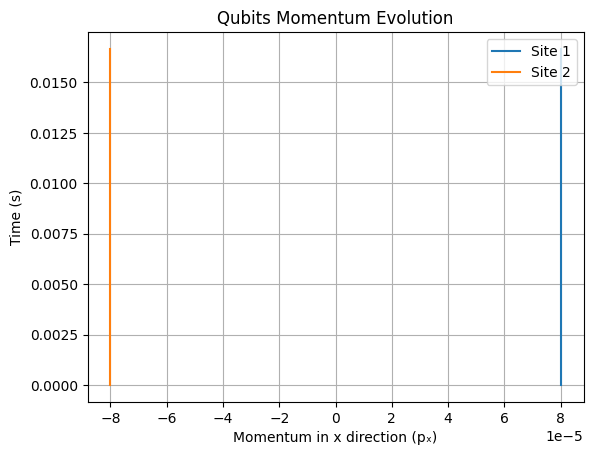

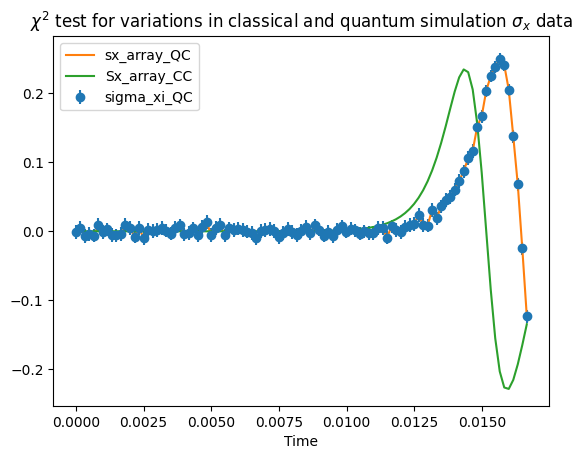

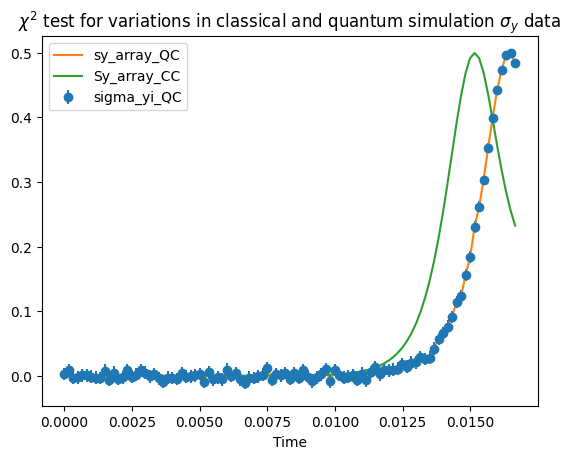

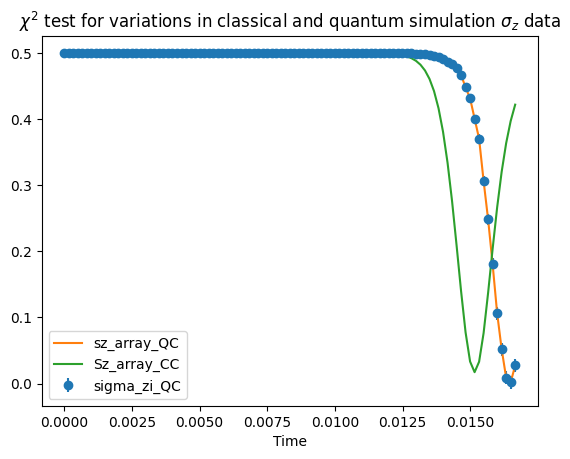

ValueError: Image size of 2210x167172 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2210.35x167172 with 1 Axes>

In [14]:
    
N_sites, theta_nu, omega, B, N, x, p, energy_sign, Δx, Δp, L, delta_m_squared,  t1, t2, del_t, Eνₑ, shape_name , shots, trotter_steps, backend,df, τ, times, ttotal,optimization_level,periodic= initialize_parameters()
pauli_terms = construct_hamiltonian(N, omega, B, N_sites, Δx, delta_m_squared, p, x, Δp, theta_nu, shape_name, L, τ, energy_sign)
sigma_x_values, sigma_y_values, sigma_z_values, survival_probabilities, x_values, pₓ_values, ρₑₑ_array, ρ_μμ_array, ρₑμ_array, circuit, sigma_xbar_i, sigma_ybar_i, sigma_zbar_i, Im_omega= evolve_and_simulate(times, omega,delta_m_squared,del_t, Eνₑ, N_sites,x, p, L, pauli_terms, theta_nu, backend, shots, τ, df,ttotal, optimization_level, periodic, trotter_steps, trotter_order)
chi_square_value, Sx_array_CC, sx_array_QC, sigma_xi_array_QC,  Sy_array_CC, sy_array_QC, sigma_yi_array_QC, Sz_array_CC, sz_array_QC, sigma_zi_array_QC = chi_square_test(N_sites, ttotal, shots)
plot_results(times,shots, sigma_x_values, sigma_y_values, sigma_z_values, survival_probabilities,x_values, pₓ_values, ρₑₑ_array, ρ_μμ_array, ρₑμ_array, Sx_array_CC, Sy_array_CC, Sz_array_CC, sx_array_QC, sy_array_QC, sz_array_QC, sigma_xi_array_QC, sigma_yi_array_QC, sigma_zi_array_QC, N_sites,ttotal)
circuit.draw(output="mpl")